## A Recommender System that uses Surprise and Custom Book Ratings Data

#### Loading and Pre-processing data

In [1]:
import pandas as pd

read_ = pd.read_csv('books_ratings.csv')

read_.head()

,Unnamed: 0,asin,reviewerID,overall
0,0,000100039X,A2S166WSCFIFP5,5.0
1,1,000100039X,A1BM81XB4QHOA3,5.0
2,2,000100039X,A1MOSTXNIO5MPJ,5.0
3,3,000100039X,A2XQ5LZHTD4AFT,5.0
4,4,000100039X,A3V1MKC2BVWY48,5.0


In [2]:
read_.drop(columns = ['Unnamed: 0'], inplace=True)


In [3]:
read_ = read_[['reviewerID', 'asin', 'overall']]

In [4]:
read_.head()

,reviewerID,asin,overall
0,A2S166WSCFIFP5,000100039X,5.0
1,A1BM81XB4QHOA3,000100039X,5.0
2,A1MOSTXNIO5MPJ,000100039X,5.0
3,A2XQ5LZHTD4AFT,000100039X,5.0
4,A3V1MKC2BVWY48,000100039X,5.0


In [24]:
user_ratings_ave= read_.groupby('reviewerID')['overall'].mean()

In [25]:
user_ratings_count = read_.groupby('reviewerID')['overall'].count()

In [27]:
user_ratings_count.head()

reviewerID
A00098481E8WIB9X660MV    1
A00109803PZJ91RLT7DPN    2
A00154983C0WD3K7FLYTW    1
A00311082372LV4OV6WJC    1
A00338282E99B8OR2JYTZ    3
Name: overall, dtype: int64

In [26]:
user_ratings_count.describe()

count    317842.000000
mean          3.146214
std           9.883328
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        2567.000000
Name: overall, dtype: float64

#### Creates a dictionary of threshold values for each user based on their average rating counts

In [31]:
from collections import defaultdict

def user_ave_rating_threshold(df, n):
    ''' Function that averages a unique reviewerID's ratings if they have reviewed more than n books
        and returns a dictionary of threshold values and ids'''
    
    
    threshold_dict = defaultdict(list)
    
    # note--> to optimize only find the mean if it means the user_Rating_count
    
    user_ratings_ave= df.groupby('reviewerID')['overall'].mean()
    user_ratings_count = df.groupby('reviewerID')['overall'].count()
    
    for x in df['reviewerID'].unique():
        if user_ratings_count[x] > n:
            threshold_dict[x] = user_ratings_ave[x]
        else:
            threshold_dict[x] = 3.5
    
    return(threshold_dict)
            
        
threshold_diction = user_ave_rating_threshold(read_, 8)
    

#### Some troubleshooting support for importing models

In [5]:
# Surprise sometimes does not import, have to check jupyter kernal
import sys

sys.executable
sys.path

'import sys\n\nsys.executable\nsys.path'

### Import and Load Surprise

In [9]:
from surprise import Reader, Dataset

# Define the format
reader = Reader(rating_scale=(1, 5))

# Load the data from the file using the reader format
data = Dataset.load_from_df(read_, reader=reader)

## Create Baseline RSME using NormalPredictor

In [12]:
from surprise.model_selection import cross_validate
from surprise import NormalPredictor


norm_preds = cross_validate(NormalPredictor(), data, cv=5)

In [ ]:
norm_preds

## Use KFold&SVD to compare to NormalPredictor()

In [13]:
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import KFold

rmse_to_ave= []
mae_to_ave = []

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error and Mean Average Error
    rmse_to_ave.append(accuracy.rmse(predictions, verbose=True))
    mae_to_ave.append(accuracy.mae(predictions, verbose=True))

RMSE: 1.0133
MAE:  0.7785
RMSE: 1.0103
MAE:  0.7762
RMSE: 1.0111
MAE:  0.7754
RMSE: 1.0101
MAE:  0.7753
RMSE: 1.0062
MAE:  0.7726


In [36]:
rmse_ave = sum(rmse_to_ave)/len(rmse_to_ave)

In [37]:
mae_ave = sum(mae_to_ave)/len(mae_to_ave)

In [40]:
#average improvements:
improve_rmse = (norm_preds['test_rmse'].mean() - rmse_ave.mean() )/norm_preds['test_rmse'].mean()
improve_mae = (norm_preds['test_mae'].mean() - mae_ave.mean() )/norm_preds['test_mae'].mean()

print("change of rmse is {0} and change of mae is {1}".format(improve_rmse,improve_mae ))

change of rmse is 0.2853777874699023 and change of mae is 0.27851448963931313


### CONCLUSION: KFold is an improvement over NormalPredictor by about 30% 

## Get Top N Recs

In [ ]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

## Use Precision and Recall Metrics Methods

### Using a base threshold at 3.5

In [85]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls



kf = KFold(n_splits=5)
algo = SVD()

prec_to_ave = []
rec_to_ave = []

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

In [86]:
def make_binary_tpr_fpr(predictions, threshold=3.5):
    pred_df = pd.DataFrame(predictions)
    pred_df['r_ui'].where(pred_df['r_ui']>threshold, 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<=threshold, 0, inplace=True)
    
    pred_df['est'].where(pred_df['est']>threshold, 1, inplace=True)
    pred_df['est'].where(pred_df['est']<=threshold, 0, inplace=True)

    return pred_df['r_ui'], pred_df['est']

true_r, est = make_binary_tpr_fpr(predictions)

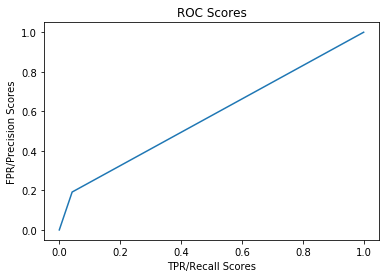

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


def graph_roc (true_r, est):
    fpr, tpr, thresholds = roc_curve(true_r, est)
    plt.plot(fpr,tpr, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores")
    plt.show()
    
graph_roc(true_r, est)

In [89]:
precision_average = sum(prec_to_ave)/len(prec_to_ave)
recall_average = sum(rec_to_ave)/len(prec_to_ave)

print("Precision and Recall averages are {0} and {1}, respectively".format(precision_average, recall_average))

Precision and Recall averages are 0.8813739408660741 and 0.8182552512459239, respectively


## Precision and Recall values using User-Average Ratings as a Threshold

In [90]:
def precision_recall_at_k(predictions, threshold_dictionary, k=10):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        threshold = threshold_dictionary[uid]

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls



kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, threshold_diction, k=5)

    # Precision and recall can then be averaged over all users
  
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

In [93]:
precision_average = sum(prec_to_ave)/len(prec_to_ave)
recall_average = sum(rec_to_ave)/len(prec_to_ave)

print("Precision and Recall averages are {0} and {1}, respectively".format(precision_average, recall_average))

Precision and Recall averages are 0.8439237949238898 and 0.8743432584414096, respectively


In [100]:
def make_binary_tpr_fpr_user(predictions, threshold_diction):
    
    pred_df = pd.DataFrame(predictions)
    
    pred_df['threshold'] = pred_df['uid'].map(threshold_diction)
    pred_df['r_ui'].where(pred_df['r_ui']>=pred_df['threshold'], 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<pred_df['threshold'], 0, inplace=True)
    pred_df['est'].where(pred_df['est']>=pred_df['threshold'], 1, inplace=True)
    pred_df['est'].where(pred_df['est']<pred_df['threshold'], 0, inplace=True)
    
    return pred_df['r_ui'], pred_df['est']

true_r_ut, est_ut = make_binary_tpr_fpr_user(predictions, threshold_diction)

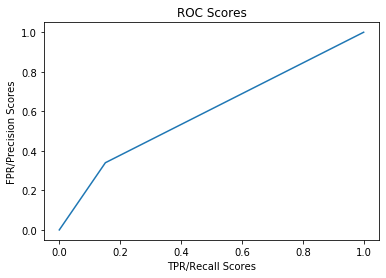

In [101]:
graph_roc(true_r_ut, est_ut)